In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import pandas as pd
import seaborn as sns
import os
import itertools
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import keras
from keras import backend
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3, ResNet152V2, VGG16

#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


##### Class to keep track of the model's history while training

In [2]:
import time
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

##### Function to calculate Root Mean Squared Error (RMSE)

In [3]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

##### Function to add more layers after the base pre-trained CNN to align the parameter numbers and outputs

In [4]:
def add_cnn_layers(base_model, model):
    model.add(base_model)
    model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.40))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(7, activation='softmax'))
    model.summary()
    return model

##### Function to calculate training + validation sets accuracy + loss + errors

In [5]:
def train_val_accuracy(model, x_train_normalized, x_val_normalized, y_train, y_val):
    train_loss, train_accuracy, train_mse, train_mape, train_rmse = model.evaluate(x_train_normalized, y_train, verbose=1)
    val_loss, val_accuracy, val_mse, val_mape, val_rmse = model.evaluate(x_val_normalized, y_val, verbose=1)
    
    #Accuracy
    print("Training Accuracy:",train_accuracy*100,"%","")
    print("Validation Accuracy:",val_accuracy*100,"%","")

    #Loss
    print("\nTraining Loss:",train_loss)
    print("Validation Loss:",val_loss)

    #RMSE
    print("\nTraining RMSE:",train_rmse)
    print("Validation RMSE:",val_rmse)

    #MSE
    print("\nTraining MSE:",train_mse)
    print("Validation MSE:",val_mse)

    #MAPE
    print("\nTraining MAPE:",train_mape)
    print("Validation MAPE:",val_mape)

##### Function to calculate testing set accuracy + loss + errors

In [6]:
def test_accuracy(model, x_test_normalized, y_test):
    test_loss, test_accuracy, test_mse, test_mape, test_rmse = model.evaluate(x_test_normalized, y_test, verbose=1)

    print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set RMSE:", test_rmse,
          "\nTest Set MSE:", test_mse,
          "\nTest Set MAPE:", test_mape)

##### Function to plot model accuracy + loss + errors against Epochs

In [7]:
def plot_model_history(model_history, name):
    fig, axs = plt.subplots(2, 2, figsize=(15,15))
    
    #Summarize history for accuracy
    axs[0,0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0,0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0,0].set_title('Model Accuracy')
    axs[0,0].set_ylabel('Accuracy')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0,0].legend(['train', 'validation'], loc='best')
    
    #Summarize history for loss
    axs[0,1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[0,1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[0,1].set_title('Model Loss')
    axs[0,1].set_ylabel('Loss')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[0,1].legend(['train', 'validation'], loc='best')
    
    #Summarize history for RMSE
    axs[1,0].plot(range(1,len(model_history.history['rmse'])+1),model_history.history['rmse'])
    axs[1,0].plot(range(1,len(model_history.history['val_rmse'])+1),model_history.history['val_rmse'])
    axs[1,0].set_title('Model RMSE')
    axs[1,0].set_ylabel('RMSE')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_xticks(np.arange(1,len(model_history.history['rmse'])+1),len(model_history.history['rmse'])/10)
    axs[1,0].legend(['train', 'validation'], loc='best')
    
    #Summarize history for MSE
    axs[1,1].plot(range(1,len(model_history.history['mse'])+1),model_history.history['mse'])
    axs[1,1].plot(range(1,len(model_history.history['val_mse'])+1),model_history.history['val_mse'])
    axs[1,1].set_title('Model MSE')
    axs[1,1].set_ylabel('MSE')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_xticks(np.arange(1,len(model_history.history['mse'])+1),len(model_history.history['mse'])/10)
    axs[1,1].legend(['train', 'validation'], loc='best')
    
    #Plot and save figures
    plt.show()
    fig.savefig('../Photos/' + name + '_model_history.png', dpi=300)

##### Function to calculate true and predicted classes

In [8]:
def cal_true_pred_classes(model, x_test_normalized, y_test):
    #Predict the values from the testing set
    y_predict = model.predict(x_test_normalized)

    #Convert prediction classes to one hot vectors 
    y_predict_classes = np.argmax(y_predict, axis = 1) 

    #Convert testing label observations to one hot vectors
    y_true_classes = np.argmax(y_test, axis = 1) 
    
    return y_predict_classes, y_true_classes

#### Function to create testing set confusion matrix for true vs predicted labels

In [9]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

##### Function to print and plot the confusion matrix for true vs predicted labels

In [10]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('../Photos/' + name + '_confusion_matrix.png', dpi=300)

##### Function to generate classification report

In [11]:
def gen_classification_report(model, x_test_normalized, y_test, cm_plot_labels):
    
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
    
    #Generate report
    report = classification_report(y_true_classes, y_predict_classes, target_names = cm_plot_labels)
    print(report)

##### Function to find out which category had the most accurate label classification %

In [12]:
def plot_label_classification_acc(model, x_test_normalized, y_test, cm_plot_labels, name):

    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
        
    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Calculation confusion matrix prediction error
    cm_prediction_error = (np.diag(confusion_matrix_computed) / np.sum(confusion_matrix_computed, axis=1))* 100

    #Bar plot
    plt.bar(np.arange(7), cm_prediction_error)

    #Plot title and labels
    plt.title(name)
    plt.xlabel('True Labels')
    plt.ylabel('Classified Labels %')
    
    #Save figure
    fig = plt
    fig.savefig('../Photos/' + name + '_label_classification_accuracy.png', dpi=300)

In [13]:
base_skin_dir = os.path.join('..', 'data')

In [ ]:
#base_skin_dir = os.path.join('C:\\Users\\Samujjwal\\Desktop\\890 project\\HAM10000_images_part_1','C:\\Users\\Samujjwal\\Desktop\\890 project\\HAM10000_images_part_2')


In [14]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [15]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [16]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

In [17]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get) #Image Local Path
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) #Full 'dx' name
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes #Unique code for each 'dx'

In [18]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                              path  \
0  ..\data\HAM10000_images_part_1\ISIC_0027419.jpg   
1  ..\data\HAM10000_images_part_1\ISIC_0025030.jpg   
2  ..\data\HAM10000_images_part_1\ISIC_0026769.jpg   
3  ..\data\HAM10000_images_part_1\ISIC_0025661.jpg   
4  ..\data\HAM10000_images_part_2\ISIC_0031633.jpg   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

In [19]:
skin_df.describe(exclude=[np.number])

lesion_id      image_id     dx dx_type    sex localization  \
count         10015         10015  10015   10015  10015        10015   
unique         7470         10015      7       4      3           15   
top     HAM_0001863  ISIC_0027301     nv   histo   male         back   
freq              6             1   6705    5340   5406         2192   

                                                   path         cell_type  
count                                             10015             10015  
unique                                            10015                 7  
top     ..\data\HAM10000_images_part_2\ISIC_0031111.jpg  Melanocytic nevi  
freq                                                  1              6705

In [20]:
skin_df.describe()

age  cell_type_idx
count  9958.000000   10015.000000
mean     51.863828       3.623964
std      16.968614       1.208859
min       0.000000       0.000000
25%      40.000000       4.000000
50%      50.000000       4.000000
75%      65.000000       4.000000
max      85.000000       6.000000

In [21]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


In [22]:
skin_df = skin_df.drop_duplicates(subset='lesion_id')
skin_df

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
6      HAM_0002761  ISIC_0029176    bkl   histo  60.0    male         face   
8      HAM_0005132  ISIC_0025837    bkl   histo  70.0  female         back   
...            ...           ...    ...     ...   ...     ...          ...   
9994   HAM_0000193  ISIC_0030877  akiec   histo  60.0  female         face   
10001  HAM_0000020  ISIC_0031922  akiec   histo  60.0  female         face   
10004  HAM_0005579  ISIC_0029309  akiec   histo  80.0    male         face   
10008  HAM_0001576  ISIC_0033705  akiec   histo  60.0    male         face   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   

                                                  path  \
0      ..\data\HAM10000_images_part_1\ISIC_0027419.jpg   
2      ..\data\HAM10000_images_part_1\ISIC_0026769.jpg   
4      ..\data\HAM10000_images_part_2\ISIC_0031633.jpg   
6      ..\data\HAM10000_images_part_1\ISIC_0029176.jpg   
8      ..\data\HAM10000_images_part_1\ISIC_0025837.jpg   
...                                                ...   
9994   ..\data\HAM10000_images_part_2\ISIC_0030877.jpg   
10001  ..\data\HAM10000_images_part_2\ISIC_0031922.jpg   
10004  ..\data\HAM10000_images_part_2\ISIC_0029309.jpg   
10008  ..\data\HAM10000_images_part_2\ISIC_0033705.jpg   
10010  ..\data\HAM10000_images_part_2\ISIC_0033084.jpg   

                            cell_type  cell_type_idx  
0      Benign keratosis-like lesions               2  
2      Benign keratosis-like lesions               2  
4      Benign keratosis-like lesions               2  
6      Benign keratosis-like lesions               2  
8      Benign keratosis-like lesions               2  
...                               ...            ...  
9994                Actinic keratoses              0  
10001               Actinic keratoses              0  
10004               Actinic keratoses              0  
10008               Actinic keratoses              0  
10010               Actinic keratoses              0  

[7470 rows x 10 columns]

In [23]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              52
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [24]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [25]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

<Figure size 864x288 with 0 Axes>

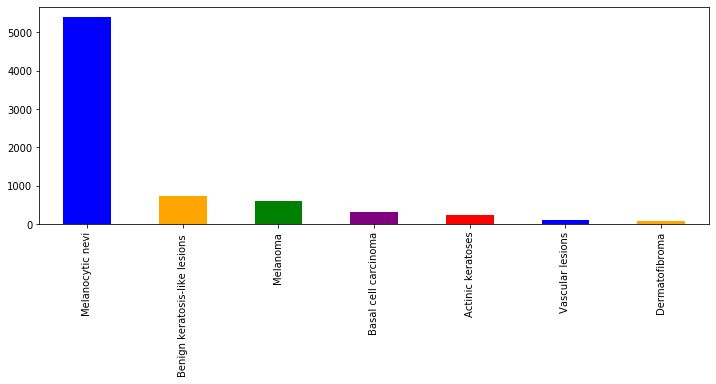

In [26]:
plt.figure(figsize=(12, 4))
skin_df['cell_type'].value_counts().plot(kind='bar', color=["blue", "orange", "green", "purple", "red"])

In [27]:
skin_df['cell_type'].value_counts()
skin_df['dx'].value_counts()

Melanocytic nevi                  5403
Benign keratosis-like lesions      727
Melanoma                           614
Basal cell carcinoma               327
Actinic keratoses                  228
Vascular lesions                    98
Dermatofibroma                      73
Name: cell_type, dtype: int64

nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
Name: dx, dtype: int64

<Figure size 864x288 with 0 Axes>

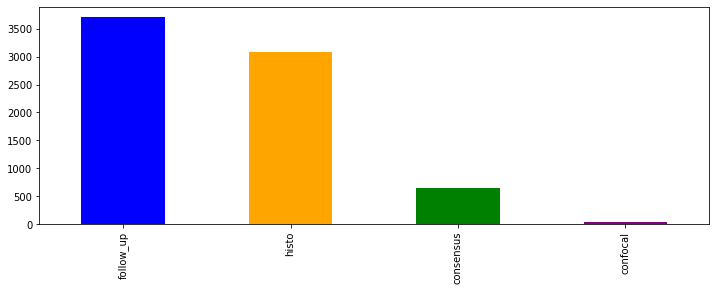

In [28]:
plt.figure(figsize=(12, 4))
skin_df['dx_type'].value_counts().plot(kind='bar', color=["blue", "orange", "green", "purple"])

<Figure size 864x288 with 0 Axes>

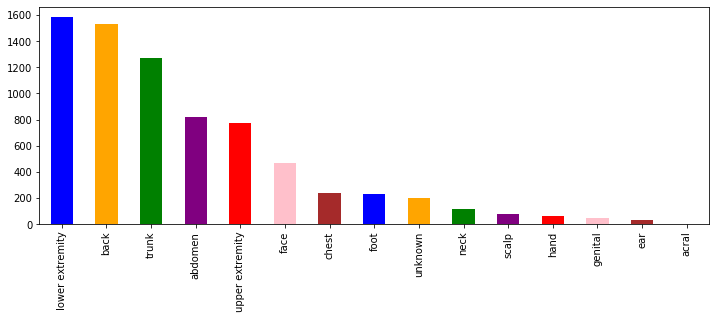

In [29]:
plt.figure(figsize=(12, 4))
skin_df['localization'].value_counts().plot(kind='bar', color=["blue", "orange", "green", "purple", "red", "pink", "brown"])

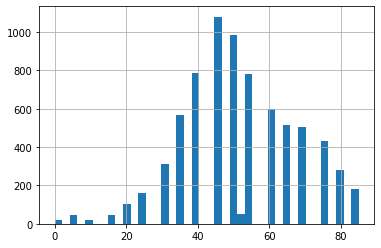

In [30]:
skin_df['age'].hist(bins=40)

It can be seen that the majority of patients reside between the ages of 35 and 70.

##### Visualize the sex distributions

<Figure size 864x288 with 0 Axes>

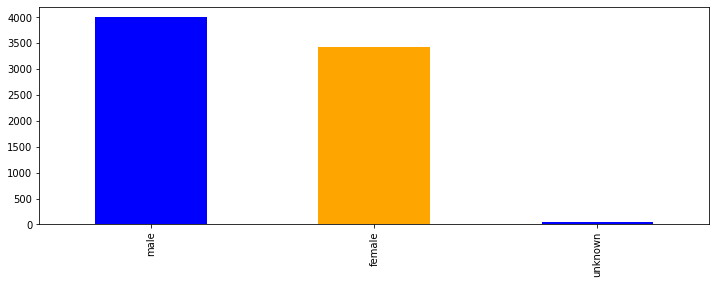

In [31]:
plt.figure(figsize=(12, 4))
skin_df['sex'].value_counts().plot(kind='bar', color=["blue", "orange"])

In [32]:
im = Image.open(skin_df["path"][0])
width, height = im.size
print("Width: ", width)
print("Height:", height)

Width:  600
Height: 450


In [33]:
width/= 4
height/= 4
print("Width: ", width)
print("Height:", height)

Width:  150.0
Height: 112.5


In [34]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((int(width), int(height)))))

In [35]:
skin_df.head(5)

lesion_id      image_id   dx dx_type   age     sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0    male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0    male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0    male          ear   
6  HAM_0002761  ISIC_0029176  bkl   histo  60.0    male         face   
8  HAM_0005132  ISIC_0025837  bkl   histo  70.0  female         back   

                                              path  \
0  ..\data\HAM10000_images_part_1\ISIC_0027419.jpg   
2  ..\data\HAM10000_images_part_1\ISIC_0026769.jpg   
4  ..\data\HAM10000_images_part_2\ISIC_0031633.jpg   
6  ..\data\HAM10000_images_part_1\ISIC_0029176.jpg   
8  ..\data\HAM10000_images_part_1\ISIC_0025837.jpg   

                        cell_type  cell_type_idx  \
0  Benign keratosis-like lesions               2   
2  Benign keratosis-like lesions               2   
4  Benign keratosis-like lesions               2   
6  Benign keratosis-like lesions               2   
8  Benign keratosis-like lesions               2   

                                               image  
0  [[[188, 151, 193], [193, 156, 198], [192, 155,...  
2  [[[186, 126, 135], [189, 131, 142], [192, 136,...  
4  [[[129, 87, 109], [139, 94, 117], [148, 102, 1...  
6  [[[190, 144, 125], [191, 145, 129], [193, 146,...  
8  [[[95, 61, 61], [105, 71, 71], [114, 77, 77], ...

In [36]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(112, 150, 3)    7470
Name: image, dtype: int64

Text(0.5, 1.0, 'Actinic keratoses')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Basal cell carcinoma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Benign keratosis-like lesions ')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Dermatofibroma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Melanocytic nevi')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Melanoma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Vascular lesions')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

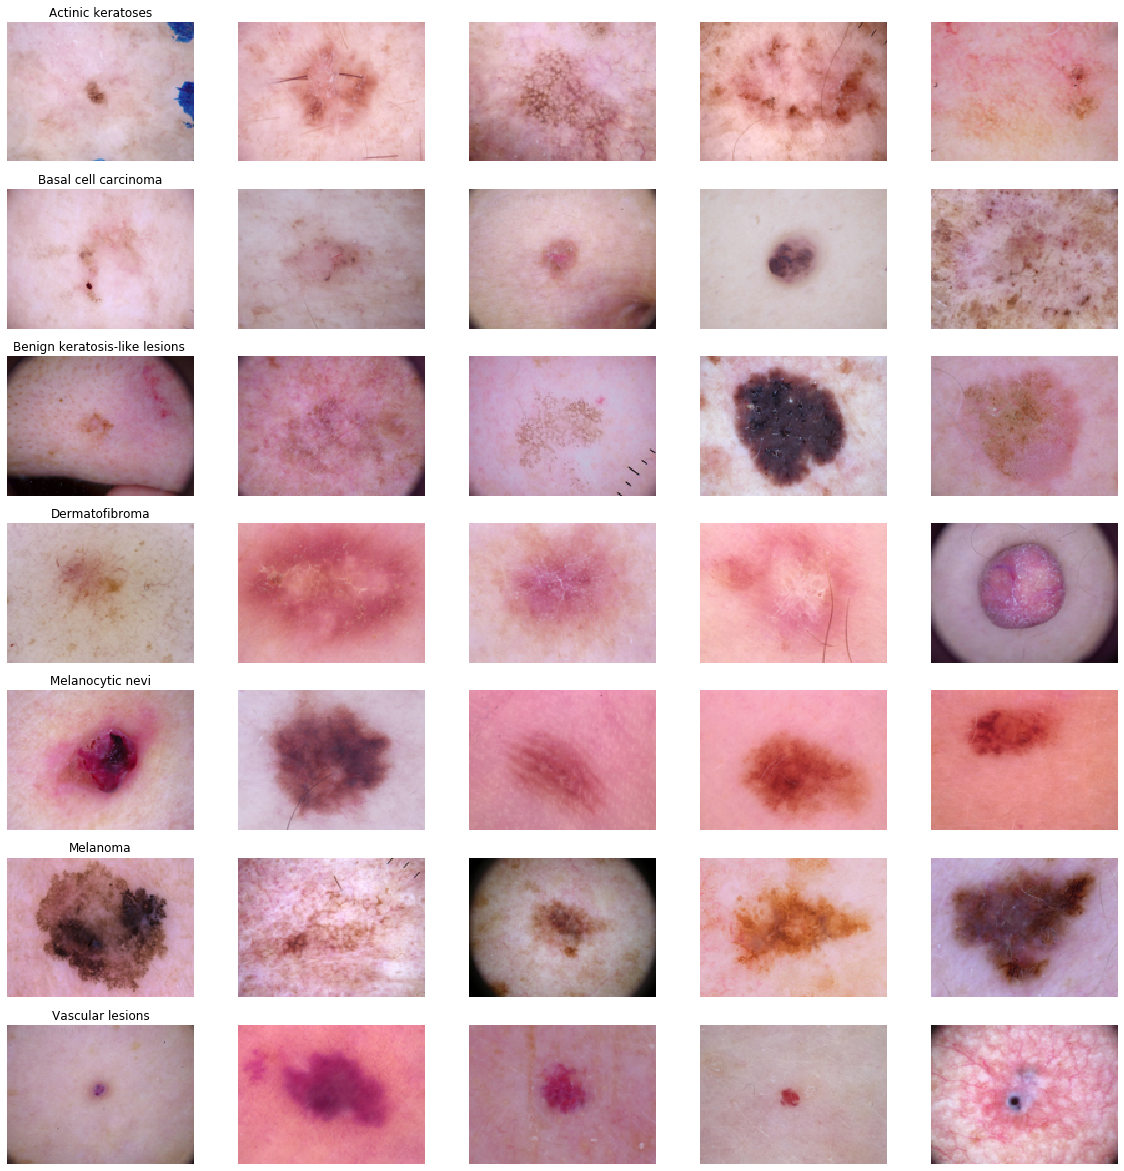

In [37]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('../Photos/category_samples.png', dpi=300)

In [38]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [39]:
num_classes = 7
target_encoded = to_categorical(target, num_classes = num_classes)
print(target_encoded)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [40]:
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.20, stratify=target_encoded)

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)

In [42]:
x_train_images = np.asarray(X_train['image'].tolist())
x_val_images = np.asarray(X_val['image'].tolist())
x_test_images = np.asarray(X_test['image'].tolist())

In [43]:
x_train_mean = np.mean(x_train_images)
x_train_std = np.std(x_train_images)

In [44]:
x_train_normalized = (x_train_images - x_train_mean)/x_train_std
x_val_normalized = (x_val_images - x_train_mean)/x_train_std
x_test_normalized = (x_test_images - x_train_mean)/x_train_std

In [45]:
input_shape = (int(width), int(height), 3)
x_train_normalized = x_train_normalized.reshape(x_train_normalized.shape[0], * (input_shape))
x_val_normalized = x_val_normalized.reshape(x_val_normalized.shape[0], * (input_shape))
x_test_normalized = x_test_normalized.reshape(x_test_normalized.shape[0], * (input_shape))

In [46]:
augmented_data = ImageDataGenerator(featurewise_center=False, 
                                    samplewise_center=False, 
                                    featurewise_std_normalization=False, 
                                    samplewise_std_normalization=False, 
                                    zca_whitening=False, 
                                    zca_epsilon=1e-06, 
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    brightness_range=None, 
                                    shear_range=0.1, 
                                    zoom_range=0.1, 
                                    channel_shift_range=0.1, 
                                    fill_mode='nearest', 
                                    cval=0.0, 
                                    horizontal_flip=False, 
                                    vertical_flip=False, 
                                    rescale=None, 
                                    preprocessing_function=None, 
                                    data_format='channels_last', 
                                    validation_split=0.0, 
                                    interpolation_order=1, 
                                    dtype='float32')

In [47]:
augmented_data.fit(x_train_normalized)

#Creating the CNN Model

In [48]:
#Keras Sequential API
#CNN Model: Conv x2 -> MaxPool -> Dropout -> Conv x2 -> MaxPool -> Dropout -> Flatten -> Dense -> Dropout -> Dense 
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 112, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 56, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 56, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 28, 64)       

In [49]:
optimizer = Adam(lr=0.001)

In [50]:
loss = "categorical_crossentropy"

In [51]:
metrics=["accuracy", 'mse', 'mape', rmse]

In [52]:
model.compile(optimizer = optimizer , loss = loss, metrics = metrics)

In [53]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [54]:
skin_df.loc[skin_df['dx'] == 'akiec', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'bcc', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'bkl', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'df', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'nv', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'mel', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'vasc', ['cell_type', 'cell_type_idx']].head(1)

cell_type  cell_type_idx
9687  Actinic keratoses              0

cell_type  cell_type_idx
2462  Basal cell carcinoma              1

cell_type  cell_type_idx
0  Benign keratosis-like lesions               2

cell_type  cell_type_idx
1095  Dermatofibroma              3

cell_type  cell_type_idx
64  Melanocytic nevi              4

cell_type  cell_type_idx
1211  Melanoma              5

cell_type  cell_type_idx
2320  Vascular lesions              6

In [56]:
epochs = 50
batch_size = 10
steps_per_epoch = len(x_train_normalized) / 10

In [59]:
# model.save('../Models/original_cnn_model.h5.h5')
# print("Saved entire model file to disk")

In [60]:
# # serialize model to JSON
# model_json = model.to_json()
# with open('../Models/original_cnn_model.h5.json', "w") as json_file:
#     json_file.write(model_json)
# print("Saved model's architecture to disk")

# # serialize weights to HDF5
# model.save_weights('../Models/original_cnn_model.h5.h5')
# print("Saved model's weights to disk")

In [61]:
loading_dependencies = {
     'rmse': rmse
}

##### Loading the saved model

In [62]:
model = load_model('../Models/original_cnn_model.h5', custom_objects=loading_dependencies)
print("Loaded entire model file from disk")

Loaded entire model file from disk


In [63]:
#model_log_data = pd.read_csv('../logs/original_cnn_training.log', sep=',', engine='python')

#InceptionV3

In [65]:
base_inception_model = InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape)

In [66]:
inception_model = Sequential()
inception_model = add_cnn_layers(base_inception_model, inception_model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 2, 2048)        21802784  
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 3, 2, 64)          1179712   
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [67]:
inception_model.compile(optimizer = optimizer , loss = loss, metrics = metrics)

In [68]:
# inception_time_callback = TimeHistory()
# inception_csv_logger = CSVLogger('../logs/inception_training.log', separator=',', append=False)
# inception_history = inception_model.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
#                                                   epochs = epochs, 
#                                                   verbose = 1,
#                                                   class_weight = class_weights,
#                                                   validation_data = (x_val_normalized, y_val), 
#                                                   steps_per_epoch = steps_per_epoch,
#                                                   callbacks=[reduce_lr, inception_time_callback, inception_csv_logger])

In [69]:
#print("\nTotal Time:",sum(inception_time_callback.times),"s\n")

In [70]:
# inception_model.save('../Models/inception_model_50epochs.h5')
# print("Saved entire model file to disk")

In [72]:
#inception_log_data = pd.read_csv('../logs/inception_training.log', sep=',', engine='python')

In [122]:
inception_model_name = "InceptionV3"

ResNet152V2

In [74]:
base_res_model = ResNet152V2(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling=None, classes=1000)

In [75]:
res_model = Sequential()
res_model = add_cnn_layers(base_res_model, res_model)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 5, 4, 2048)        58331648  
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 5, 4, 64)          1179712   
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)              

In [76]:
res_model.compile(optimizer = optimizer , loss = loss, metrics = metrics)

In [77]:
# res_time_callback = TimeHistory()
# res_csv_logger = CSVLogger('../logs/res_training.log', separator=',', append=False) 
# res_history = res_model.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
#                                       epochs = epochs, 
#                                       verbose = 1,
#                                       class_weight = class_weights,
#                                       validation_data = (x_val_normalized, y_val), 
#                                       steps_per_epoch = steps_per_epoch,
#                                       callbacks=[reduce_lr, res_time_callback, res_csv_logger])

In [78]:
#print("\nTotal Time:",sum(res_time_callback.times),"s\n")

In [79]:
# res_model.save('../Models/res_model_50epochs.h5')
# print("Saved entire model file to disk")

In [81]:
#res_log_data = pd.read_csv('../logs/res_training.log', sep=',', engine='python')

In [123]:
res_model_name = "ResNet152V2"

VGG16

In [139]:
base_vgg_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet', input_tensor=None, pooling=None, classes=1000)

In [140]:
vgg_model = Sequential()
vgg_model = add_cnn_layers(base_vgg_model, vgg_model)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 3, 512)         14714688  
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 4, 3, 64)          294976    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 2, 1, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2, 1, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)              

In [141]:
vgg_model.compile(optimizer = optimizer , loss = loss, metrics = metrics)

In [86]:
# vgg_time_callback = TimeHistory()
# vgg_csv_logger = CSVLogger('../logs/vgg_training.log', separator=',', append=False) 
# vgg_history = vgg_model.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
#                                       epochs = epochs, 
#                                       verbose = 1,
#                                       class_weight = class_weights,
#                                       validation_data = (x_val_normalized, y_val), 
#                                       steps_per_epoch = steps_per_epoch,
#                                       callbacks=[reduce_lr, vgg_time_callback, vgg_csv_logger])

In [87]:
#print("\nTotal Time:",sum(vgg_time_callback.times),"s\n")

In [88]:
# vgg_model.save('../Models/vgg_model_50epochs.h5')
# print("Saved entire model file to disk")

In [142]:
vgg_model = load_model('../Models/vgg_model.h5', custom_objects=loading_dependencies)
print("Loaded entire model file from disk")

Loaded entire model file from disk


In [90]:
#vgg_log_data = pd.read_csv('../logs/vgg_training.log', sep=',', engine='python')

In [143]:
vgg_model_name = "VGG16"

Calculate Training and Validation Sets Accuracy + Loss + Errors

InceptionV3

In [93]:
train_val_accuracy(inception_model, x_train_normalized, x_val_normalized, y_train, y_val)

1196/1196 [==============================] - 4s 3ms/step
Training Accuracy: 76.4225959777832 % 
Validation Accuracy: 75.66889524459839 % 

Training Loss: 0.7811996441131855
Validation Loss: 0.7843880081256497

Training RMSE: 0.11830007284879684
Validation RMSE: 0.12018147855997086

Training MSE: 0.048901814967393875
Validation MSE: 0.04991349205374718

Training MAPE: 35370120.0
Validation MAPE: 35893688.0


ResNet152V2

In [94]:
train_val_accuracy(res_model, x_train_normalized, x_val_normalized, y_train, y_val)

1196/1196 [==============================] - 13s 11ms/step
Training Accuracy: 82.15481042861938 % 
Validation Accuracy: 82.10702538490295 % 

Training Loss: 0.6957003326595578
Validation Loss: 0.6725385868828432

Training RMSE: 0.09633179754018784
Validation RMSE: 0.0969826877117157

Training MSE: 0.039011210203170776
Validation MSE: 0.039136700332164764

Training MAPE: 28337978.0
Validation MAPE: 28659372.0


VGG16

In [144]:
train_val_accuracy(vgg_model, x_train_normalized, x_val_normalized, y_train, y_val)

1196/1196 [==============================] - 5s 4ms/step
Training Accuracy: 88.66108655929565 % 
Validation Accuracy: 89.46488499641418 % 

Training Loss: 0.5422141460674545
Validation Loss: 0.5393182682153772

Training RMSE: 0.06458709388971329
Validation RMSE: 0.06128228083252907

Training MSE: 0.025963928550481796
Validation MSE: 0.024449700489640236

Training MAPE: 18697074.0
Validation MAPE: 17620424.0


Testing Set Accuracy + Loss + Errors

##### InceptionV3

In [101]:
test_accuracy(inception_model, x_test_normalized, y_test)

1494/1494 [==============================] - 8s 5ms/step

Test Set Accuracy:  75.70281028747559 % 
Test Set Loss: 0.7881036776615434 
Test Set RMSE: 0.11842918395996094 
Test Set MSE: 0.04949933663010597 
Test Set MAPE: 35276928.0


##### ResNet152V2

In [102]:
test_accuracy(res_model, x_test_normalized, y_test)

1494/1494 [==============================] - 17s 12ms/step

Test Set Accuracy:  81.99464678764343 % 
Test Set Loss: 0.6651405032419935 
Test Set RMSE: 0.09388057887554169 
Test Set MSE: 0.038318052887916565 
Test Set MAPE: 27543040.0


##### VGG16

In [145]:
test_accuracy(vgg_model, x_test_normalized, y_test)

1494/1494 [==============================] - 6s 4ms/step

Test Set Accuracy:  90.09370803833008 % 
Test Set Loss: 0.5345400966494438 
Test Set RMSE: 0.058850087225437164 
Test Set MSE: 0.022610504180192947 
Test Set MAPE: 17135850.0


In [104]:
#Define the labels of the class indices. These need to match the order shown above.
cm_plot_labels=['akiec', 'bcc', 'bkl', 'df', 'nv','mel', 'vasc']

InceptionV3

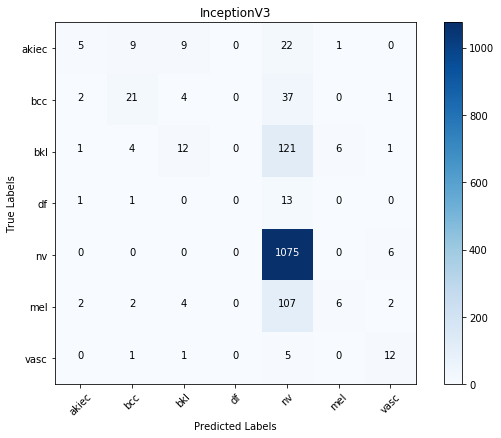

In [126]:
create_confusion_matrix(inception_model, x_test_normalized, y_test, cm_plot_labels, inception_model_name)

ResNet152V2

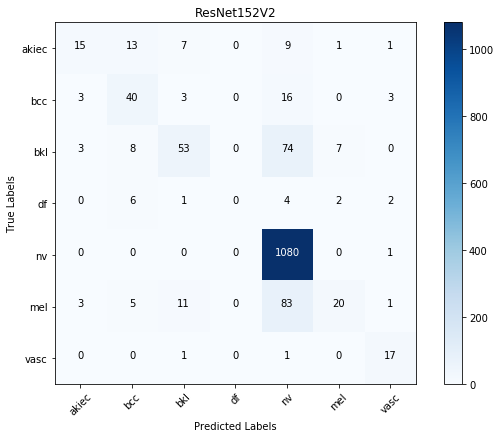

In [127]:
create_confusion_matrix(res_model, x_test_normalized, y_test, cm_plot_labels, res_model_name)

VGG16

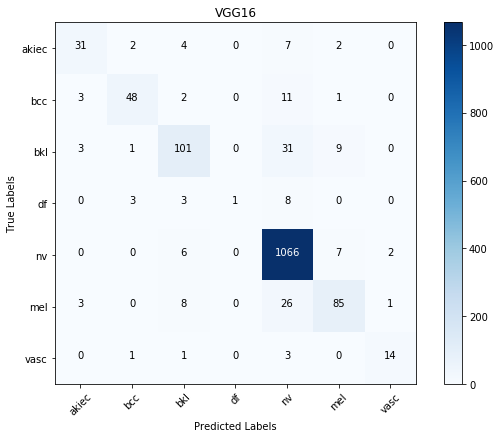

In [136]:
create_confusion_matrix(vgg_model, x_test_normalized, y_test, cm_plot_labels, vgg_model_name)

Confusion Matrix Classification Report

##### InceptionV3

In [110]:
gen_classification_report(inception_model, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

       akiec       0.45      0.11      0.18        46
         bcc       0.55      0.32      0.41        65
         bkl       0.40      0.08      0.14       145
          df       0.00      0.00      0.00        15
          nv       0.78      0.99      0.87      1081
         mel       0.46      0.05      0.09       123
        vasc       0.55      0.63      0.59        19

    accuracy                           0.76      1494
   macro avg       0.46      0.31      0.32      1494
weighted avg       0.69      0.76      0.68      1494



##### ResNet152V2

In [111]:
gen_classification_report(res_model, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

       akiec       0.62      0.33      0.43        46
         bcc       0.56      0.62      0.58        65
         bkl       0.70      0.37      0.48       145
          df       0.00      0.00      0.00        15
          nv       0.85      1.00      0.92      1081
         mel       0.67      0.16      0.26       123
        vasc       0.68      0.89      0.77        19

    accuracy                           0.82      1494
   macro avg       0.58      0.48      0.49      1494
weighted avg       0.79      0.82      0.78      1494



##### VGG16

In [137]:
gen_classification_report(vgg_model, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

       akiec       0.78      0.67      0.72        46
         bcc       0.87      0.74      0.80        65
         bkl       0.81      0.70      0.75       145
          df       1.00      0.07      0.12        15
          nv       0.93      0.99      0.95      1081
         mel       0.82      0.69      0.75       123
        vasc       0.82      0.74      0.78        19

    accuracy                           0.90      1494
   macro avg       0.86      0.66      0.70      1494
weighted avg       0.90      0.90      0.89      1494



##### InceptionV3

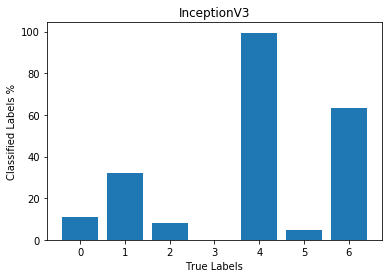

In [130]:
plot_label_classification_acc(inception_model, x_test_normalized, y_test, cm_plot_labels, inception_model_name)

##### ResNet152V2

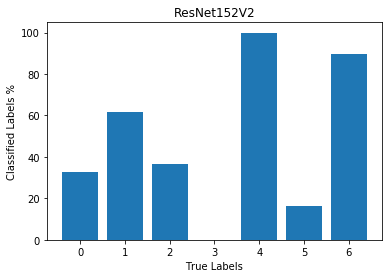

In [131]:
plot_label_classification_acc(res_model, x_test_normalized, y_test, cm_plot_labels, res_model_name)

##### VGG16

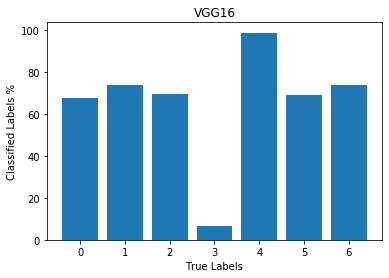

In [138]:
plot_label_classification_acc(vgg_model, x_test_normalized, y_test, cm_plot_labels, vgg_model_name)